In [51]:
from preprocess import cargar_y_preprocesar_datos
from utils import print_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
ruta = "./data/credit_card_fraud_dataset.csv"
X_train, X_val, X_test, y_train, y_val, y_test = cargar_y_preprocesar_datos(ruta)

In [53]:
print("--- Formas de los conjuntos de datos ---")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")
print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())

--- Formas de los conjuntos de datos ---
X_train: (60000, 15), y_train: (60000,)
X_val:   (20000, 15), y_val:   (20000,)
X_test:  (20000, 15), y_test:  (20000,)

Distribución de clases en el conjunto de entrenamiento:
IsFraud
0    59400
1      600
Name: count, dtype: int64


Modelo Base (Sin manejo de desbalanceo) 

Este modelo sirve como punto de referencia para medir las mejoras.

In [54]:
modelo_base = LogisticRegression(solver='liblinear', random_state=42)
modelo_base.fit(X_train, y_train)

print("\n--- Evaluación del Modelo Base en el conjunto de Validación ---")
y_pred_base = modelo_base.predict(X_val)
print("Matriz de Confusión:")
print(confusion_matrix(y_val, y_pred_base))
print("\nReporte de Clasificación:")

print(classification_report(y_val, y_pred_base, zero_division=0))
print("El modelo base ignora por completo la clase minoritaria (fraude) y predice siempre 'no fraude'.")
print("Aunque la exactitud (accuracy) es alta (99%), el modelo es inútil para nuestro objetivo.")


--- Evaluación del Modelo Base en el conjunto de Validación ---
Matriz de Confusión:
[[19800     0]
 [  200     0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19800
           1       0.00      0.00      0.00       200

    accuracy                           0.99     20000
   macro avg       0.49      0.50      0.50     20000
weighted avg       0.98      0.99      0.99     20000

El modelo base ignora por completo la clase minoritaria (fraude) y predice siempre 'no fraude'.
Aunque la exactitud (accuracy) es alta (99%), el modelo es inútil para nuestro objetivo.


Primera Solución: Ponderación de Clases

Se utiliza **class_weight='balanced'** para penalizar más los errores en la clase minoritaria.

In [55]:
modelo_balanceado = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
modelo_balanceado.fit(X_train, y_train)

print("\n--- Evaluación del Modelo con Ponderación en Validación ---")
y_pred_balanceado = modelo_balanceado.predict(X_val)
print("Matriz de Confusión:")
print(confusion_matrix(y_val, y_pred_balanceado))
print("\nReporte de Clasificación:")
print(classification_report(y_val, y_pred_balanceado))
print("El modelo ahora detecta algunos fraudes (aumenta el recall), pero a costa de muchísimos falsos positivos (precisión muy baja).")


--- Evaluación del Modelo con Ponderación en Validación ---
Matriz de Confusión:
[[10023  9777]
 [   91   109]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.51      0.67     19800
           1       0.01      0.55      0.02       200

    accuracy                           0.51     20000
   macro avg       0.50      0.53      0.35     20000
weighted avg       0.98      0.51      0.66     20000

El modelo ahora detecta algunos fraudes (aumenta el recall), pero a costa de muchísimos falsos positivos (precisión muy baja).


Solución Avanzada: Pipeline con SMOTE y Submuestreo 

Para un mejor control, creamos un pipeline que primero aplica SMOTE para generar muestras sintéticas de la clase minoritaria, y luego aplica submuestreo aleatorio para reducir la clase mayoritaria.

Usar un pipeline de `imblearn` es crucial para evitar el "data leakage", ya que el remuestreo se ajusta solo a los datos de entrenamiento durante el `fit`.

In [56]:
# Definición del pipeline
# 1. SMOTE: Aumenta la clase minoritaria hasta que represente el 10% de la clase mayoritaria.
# 2. RandomUnderSampler: Reduce la clase mayoritaria hasta que sea el 50% de la minoritaria.
# 3. LogisticRegression: El modelo se entrena sobre los datos ya rebalanceados. NO se usa class_weight.
pipeline_resampling = Pipeline([
    ('oversample', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('model', LogisticRegression(solver='liblinear', random_state=42))
])

pipeline_resampling.fit(X_train, y_train)

print("\n--- Evaluación del Pipeline en Validación (con umbral por defecto 0.5) ---")
y_pred_pipeline = pipeline_resampling.predict(X_val)
print("Matriz de Confusión:")
print(confusion_matrix(y_val, y_pred_pipeline))
print("\nReporte de Clasificación:")
print(classification_report(y_val, y_pred_pipeline))
print("Este modelo ofrece un mejor punto de partida que las soluciones anteriores.")


--- Evaluación del Pipeline en Validación (con umbral por defecto 0.5) ---
Matriz de Confusión:
[[19800     0]
 [  200     0]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19800
           1       0.00      0.00      0.00       200

    accuracy                           0.99     20000
   macro avg       0.49      0.50      0.50     20000
weighted avg       0.98      0.99      0.99     20000

Este modelo ofrece un mejor punto de partida que las soluciones anteriores.


c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Angelica\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Ajuste del Umbral de Decisión

Ahora que tenemos un modelo más robusto, podemos ajustar el umbral de probabilidad para optimizar el balance entre precisión y recall, buscando maximizar el F1-score.




--- 5. Ajustando el umbral de decisión del modelo del pipeline ---
Mejor umbral encontrado: 0.2034
F1-Score máximo en validación: 0.0237


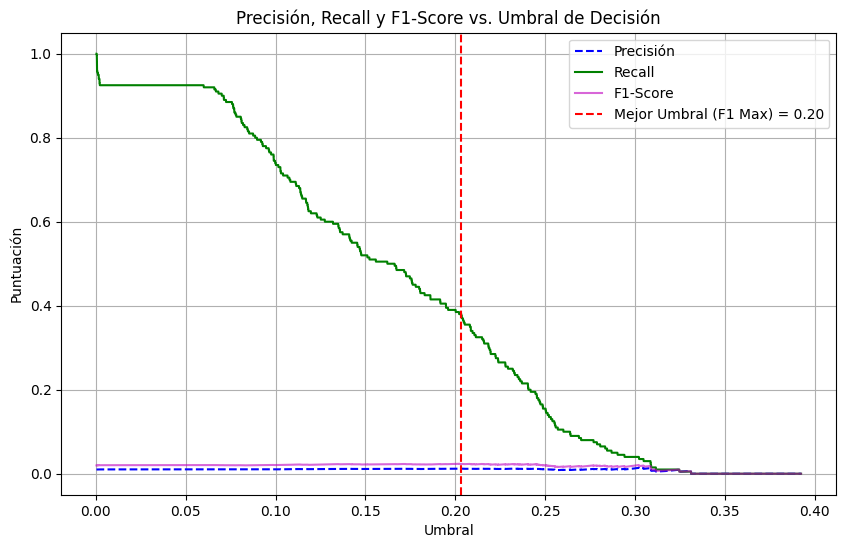

In [57]:
print("\n\n--- 5. Ajustando el umbral de decisión del modelo del pipeline ---")
# Obtener probabilidades para la clase positiva (fraude)
y_scores = pipeline_resampling.predict_proba(X_val)[:, 1]

# Calcular precisión, recall y umbrales
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

# Calcular F1-scores para cada umbral (evitando división por cero)
# Se suma una pequeña constante (epsilon) para evitar el warning de división por cero
epsilon = 1e-7
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + epsilon)

# Encontrar el mejor umbral que maximiza el F1-score
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"Mejor umbral encontrado: {best_threshold:.4f}")
print(f"F1-Score máximo en validación: {f1_scores[best_threshold_idx]:.4f}")

# Visualización de la curva de Precisión-Recall vs Umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precisión")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "m-", label="F1-Score", alpha=0.6)
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Mejor Umbral (F1 Max) = {best_threshold:.2f}')
plt.title("Precisión, Recall y F1-Score vs. Umbral de Decisión")
plt.xlabel("Umbral")
plt.ylabel("Puntuación")
plt.grid(True)
plt.legend()
plt.show()



In [58]:
# --- 6. Evaluación Final con el Umbral Optimizado ---
# Usamos el mejor umbral para hacer las predicciones finales en el conjunto de validación.

print("\n\n--- 6. Evaluación Final del Pipeline en Validación con Umbral Optimizado ---")
y_pred_final = (y_scores >= best_threshold).astype(int)

print("Matriz de Confusión Final:")
print(confusion_matrix(y_val, y_pred_final))
print("\nReporte de Clasificación Final:")
print(classification_report(y_val, y_pred_final))

roc_auc = roc_auc_score(y_val, y_scores)
print(f"ROC AUC Score: {roc_auc:.4f}")



--- 6. Evaluación Final del Pipeline en Validación con Umbral Optimizado ---
Matriz de Confusión Final:
[[13657  6143]
 [  124    76]]

Reporte de Clasificación Final:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     19800
           1       0.01      0.38      0.02       200

    accuracy                           0.69     20000
   macro avg       0.50      0.53      0.42     20000
weighted avg       0.98      0.69      0.81     20000

ROC AUC Score: 0.5361

Conclusión: El modelo final, que combina un pipeline de remuestreo y un ajuste de umbral,
logra un equilibrio mucho más razonable para la detección de fraude, mejorando significativamente
el recall de la clase minoritaria sin sacrificar por completo la precisión.
